In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
import hdbscan
from sklearn.manifold import TSNE
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.utils import plot_model


### DATA PREPARATION

In [44]:
# Read in the data
# Main change from v2 to v3 is that the specific regions have been replaced with general regions
cmd_data = pd.read_csv('/data2/home/prasannaiyer/Projects/SKU_Cluster_Local/SKU_Clusters/Data/cmd_attributes_v3_upload.csv',\
    encoding = 'latin-1', decimal = '.', thousands = ',')

In [45]:
cmd_data['p_bu'] = cmd_data['p_bu'].replace({'AW': 'AG', 'CW': 'CE'})

In [46]:
sku_count = cmd_data.shape[0]

In [47]:
attr_input = ['Attr1_Str_qu', 'Attr2_OpPr_qu','Attr3_Costamount_norm',
       'Attr4_RdDi_norm', 'Attr5_BrDi_norm', 'Attr5_Str_Type1',
       'Attr5_Str_Type2', 'Attr5_Str_Type3', 'Attr6_Major_Type1',
       'Attr6_Major_Type2', 'Attr9_Frctn0', 'Attr9_Frctn1', 'Attr10_Snsr0', 'Attr10_Snsr1']

In [48]:
attr_input_cost_model = ['Attr1_Str_qu', 'Attr2_OpPr_qu',
       'Attr4_RdDi_norm', 'Attr5_BrDi_norm', 'Attr5_Str_Type1',
       'Attr5_Str_Type2', 'Attr5_Str_Type3', 'Attr6_Major_Type1',
       'Attr6_Major_Type2', 'Attr9_Frctn0', 'Attr9_Frctn1', 'Attr10_Snsr0', 'Attr10_Snsr1']
attr_input_subset = ['Attr1_Str_qu', 'Attr2_OpPr_qu', 'Attr3_Costamount_norm',
       'Attr4_RdDi_norm', 'Attr5_BrDi_norm', 'Attr9_Frctn0', 'Attr9_Frctn1']
attr_input_subset_cost = ['Attr1_Str_qu', 'Attr2_OpPr_qu', 'Attr3_Costamount_norm',
       'Attr4_RdDi_norm', 'Attr5_BrDi_norm', 'Attr9_Frctn0', 'Attr9_Frctn1']

In [49]:
# create an autoencoder class. For init function, input would be the input data, output data, layers. Also in the init function, create the autoencoder model
# For the fit function, input would be the number of epochs, batch size, and the learning rate

class auto_encoder:
    def __init__(self, input_data, output_data, ae_layers, alpha_ae = 0.2):
        self.input_data = input_data
        self.output_data = output_data
        self.ae_layers = ae_layers
        self.alpha_ae = alpha_ae
        self.autoencoder = self.create_autoencoder()
                
    def create_autoencoder(self):
        # create the input layer
        encoder_input = Input(shape=(self.input_data.shape[1],))
        nn_layer = encoder_input
        # create the encoder layers
        for i in range(len(self.ae_layers)):
            layer_name = 'encoder_layer_' + str(i+1)
            layer_name = Dense(self.ae_layers[i])(nn_layer)
            layer_name = LeakyReLU(alpha=self.alpha_ae)(layer_name)
            nn_layer = layer_name
        encoder_output = nn_layer
        self.encoder_model = Model(encoder_input, encoder_output)
        # create the decoder layers
        for i in range(len(self.ae_layers)-2, -1, -1):
            layer_name = 'decoder_layer_' + str(i+1)
            layer_name = Dense(self.ae_layers[i])(nn_layer)
            layer_name = LeakyReLU(alpha=self.alpha_ae)(layer_name)
            nn_layer = layer_name
        decoder_output = nn_layer
        # create the output layer
        autoencoder_output = Dense(self.output_data.shape[1], activation = 'linear')(nn_layer)
        self.ae_model = Model(encoder_input, autoencoder_output)
        # compile the model
        self.ae_model.compile(optimizer='adam', loss='mse')

    # Create a function to fit the model
    def autoencoder_fit(self, epochs = 500, batch_size = 32, verbose = 1):
        self.ae_model_hist = self.ae_model.fit(self.input_data, self.output_data, epochs = epochs, batch_size = batch_size, verbose = verbose)

    # Create a function to plot the training loss
    def plot_training_loss(self):
        plt.figure(figsize = (10, 6))
        ax = sns.lineplot(x = range(1, len(self.ae_model_hist.history['loss']) + 1), y = self.ae_model_hist.history['loss'])
        ax.set_xlabel('Epochs')
        ax.set_ylabel('Training Loss')
        ax.set_title('Training Loss vs Epochs')
        ax.grid(linestyle='-', linewidth='0.5', color='red')

    # create a function to print the loss for epochs at specified intervals
    def print_loss(self, interval = 500):
        for i in range(0, len(self.ae_model_hist.history['loss']), interval):
            print(f'Loss at epoch {i}: {self.ae_model_hist.history["loss"][i]:.4f}')
        # print the loss at the last epoch using f-string
        print(f'Loss at epoch {len(self.ae_model_hist.history["loss"])}: {self.ae_model_hist.history["loss"][-1]:.4f}')
        
        # print minimum loss and the epoch at which it occurs
        # print(f'Minimum loss: {min(self.ae_model_hist.history['loss']):.4f} at epoch {self.ae_model_hist.history['loss'].index(min(self.ae_model_hist.history['loss']))}')
        print(f'Minimum loss: {min(self.ae_model_hist.history["loss"]):.4f} at epoch {np.argmin(self.ae_model_hist.history["loss"])}')
    
    


In [50]:
# Function to create clusters of the input data
def create_clusters(input_data, cluster_algorithm = 'k-means'):
    if cluster_algorithm == 'k-means':
        # create the k-means model
        kmeans = KMeans(n_clusters = 8, random_state = 42)
        # fit the model
        return kmeans.fit_predict(input_data)        
    elif cluster_algorithm == 'hdbscan':
        # create the hdbscan model
        hdbscan_cluster = hdbscan.HDBSCAN(min_cluster_size = 15, min_samples = 10, gen_min_span_tree = True)
        # fit the model
        return hdbscan_cluster.fit_predict(input_data)    


In [51]:
input_size = len(attr_input)
ae_layers = [input_size*2, 32, 16, 8]
ae_model = auto_encoder(cmd_data[attr_input], cmd_data[attr_input], ae_layers)

In [52]:
# fit the model
# ae_model_hist = ae_model.ae_model.fit(cmd_data[attr_input], cmd_data[attr_input], epochs = 500, batch_size = 32, verbose = 1)
ae_model.autoencoder_fit(epochs = 500, batch_size = 32, verbose = 1)

Epoch 1/500
21/21 [==============================] - 0s 1ms/step - loss: 0.4675
Epoch 2/500
21/21 [==============================] - 0s 1ms/step - loss: 0.3186
Epoch 3/500
21/21 [==============================] - 0s 1ms/step - loss: 0.2341
Epoch 4/500
21/21 [==============================] - 0s 1ms/step - loss: 0.1606
Epoch 5/500
21/21 [==============================] - 0s 1ms/step - loss: 0.1089
Epoch 6/500
21/21 [==============================] - 0s 1ms/step - loss: 0.0855
Epoch 7/500
21/21 [==============================] - 0s 1ms/step - loss: 0.0764
Epoch 8/500
21/21 [==============================] - 0s 1ms/step - loss: 0.0725
Epoch 9/500
21/21 [==============================] - 0s 1ms/step - loss: 0.0690
Epoch 10/500
21/21 [==============================] - 0s 1ms/step - loss: 0.0645
Epoch 11/500
21/21 [==============================] - 0s 1ms/step - loss: 0.0593
Epoch 12/500
21/21 [==============================] - 0s 1ms/step - loss: 0.0523
Epoch 13/500
21/21 [=================

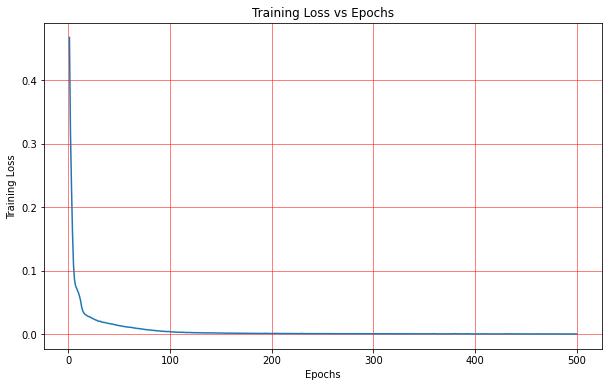

In [53]:
ae_model.plot_training_loss()

In [54]:
ae_model.print_loss()

Loss at epoch 0: 0.4675
Loss at epoch 500: 0.0003
Minimum loss: 0.0002 at epoch 496


In [55]:
cmd_data['kmeans_labels'] = create_clusters(cmd_data[attr_input], cluster_algorithm = 'k-means')

In [56]:
cmd_data['hdbscan_labels'] = create_clusters(cmd_data[attr_input], cluster_algorithm = 'hdbscan')

In [57]:
cmd_data[cmd_data['p_bu'].isin(['AG', 'CE'])].shape

(454, 30)

In [58]:
cmd_data.columns

Index(['Attr1_Str_qu', 'Attr2_OpPr_qu', 'Attr3_Costamount_norm',
       'Attr4_RdDi_norm', 'Attr5_BrDi_norm', 'Attr5_Str_Type1',
       'Attr5_Str_Type2', 'Attr5_Str_Type3', 'Attr6_Major_Type1',
       'Attr6_Major_Type2', 'Attr7_Cshn1', 'Attr7_Cshn2', 'Attr7_Cshn3',
       'Attr7_Cshn4', 'Attr8_Repha1', 'Attr8_Repha2', 'Attr8_Repha3',
       'Attr9_Frctn0', 'Attr9_Frctn1', 'Attr10_Snsr0', 'Attr10_Snsr1',
       'partnumber', 's_nm', 's_country', 's_region', 'p_nm', 'p_bu',
       'p_region', 'kmeans_labels', 'hdbscan_labels'],
      dtype='object')

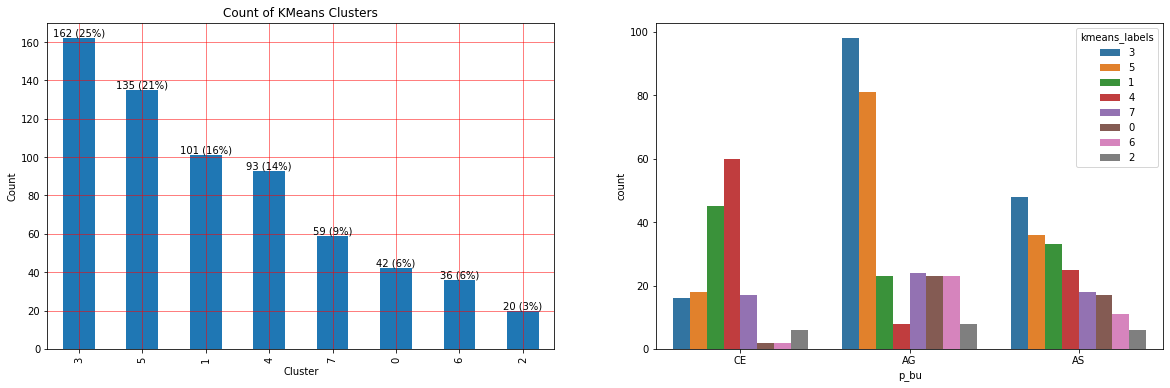

In [59]:
fig = plt.figure(figsize = (20, 6))
ax = cmd_data.groupby(by = 'kmeans_labels')['p_nm'].count().sort_values(ascending = False).plot(kind = 'bar', ax = fig.add_subplot(121))
ax.bar_label(ax.containers[0], labels = [f'{x} ({(x/sku_count)*100:,.0f}%)' for x in ax.containers[0].datavalues])
ax.set_xlabel('Cluster')
ax.set_ylabel('Count')
ax.set_title('Count of KMeans Clusters')
ax.grid(linestyle='-', linewidth='0.5', color='red')

ax = fig.add_subplot(122)
ax = sns.countplot(x = 'p_bu', hue = 'kmeans_labels', hue_order = [3, 5, 1,4,7,0, 6, 2], data = cmd_data)


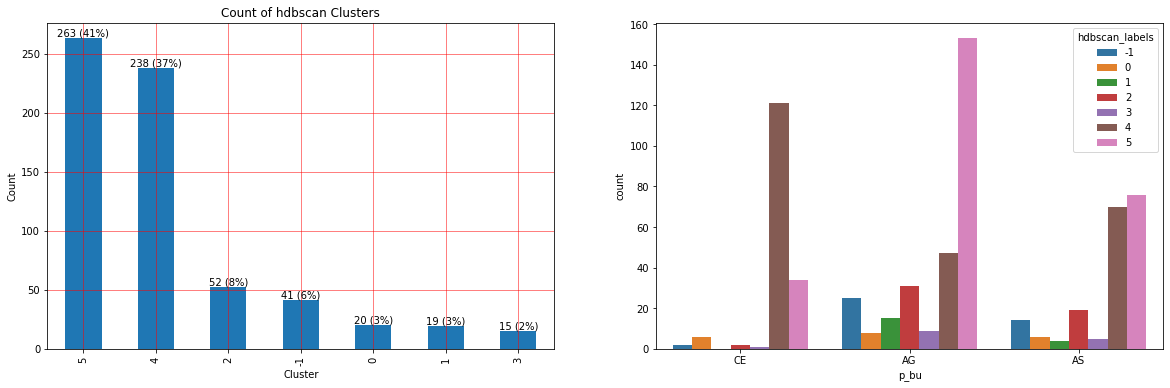

In [68]:
fig = plt.figure(figsize = (20, 6))
ax = cmd_data.groupby(by = 'hdbscan_labels')['p_nm'].count().sort_values(ascending = False).plot(kind = 'bar', ax = fig.add_subplot(121))
ax.bar_label(ax.containers[0], labels = [f'{x} ({(x/sku_count)*100:,.0f}%)' for x in ax.containers[0].datavalues])
ax.set_xlabel('Cluster')
ax.set_ylabel('Count')
ax.set_title('Count of hdbscan Clusters')
ax.grid(linestyle='-', linewidth='0.5', color='red')

ax = fig.add_subplot(122)
ax = sns.countplot(x = 'p_bu', hue = 'hdbscan_labels', data = cmd_data)

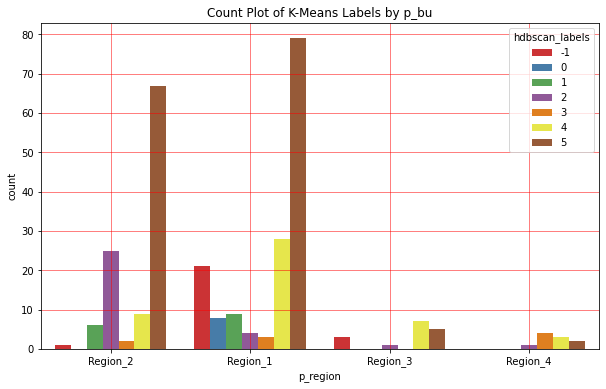

In [60]:
fig, ax = plt.subplots(figsize = (10, 6))
sns.countplot(x = 'p_region', hue = 'hdbscan_labels', data = cmd_data[cmd_data['p_bu'].isin(['AG'])], ax = ax, palette = 'Set1')
ax.set_title('Count Plot of K-Means Labels by p_bu')
ax.grid(linestyle='-', linewidth='0.5', color='red')

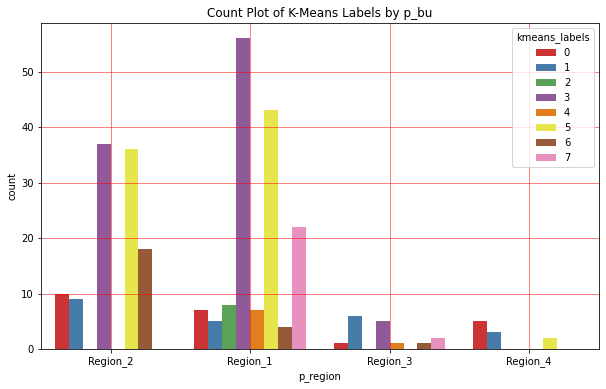

In [61]:
# Seaborn count plot with x-axis as p_bu with hue as kmeans_labels
fig, ax = plt.subplots(figsize = (10, 6))
sns.countplot(x = 'p_region', hue = 'kmeans_labels', data = cmd_data[cmd_data['p_bu'].isin(['AG'])], ax = ax, palette = 'Set1')
ax.set_title('Count Plot of K-Means Labels by p_bu')
ax.grid(linestyle='-', linewidth='0.5', color='red')


In [62]:
input_size = cmd_data[attr_input].shape[1]
l1_size = input_size*2
l2_size = 32
l3_size = 16
bottleneck_size = 8
encoder_input = Input(shape = (input_size, ))
# encoder layer 1
encoder_m5_l1 = Dense(l1_size)(encoder_input)
encoder_m5_l1 = LeakyReLU()(encoder_m5_l1)
# encoder layer 2
encoder_m5_l2 = Dense(l2_size)(encoder_m5_l1)
encoder_m5_l2 = LeakyReLU()(encoder_m5_l2)
# encoder layer 3
encoder_m5_l3 = Dense(l3_size)(encoder_m5_l2)
encoder_m5_l3 = LeakyReLU()(encoder_m5_l3)
# encoder bottleneck layer
encoder_m5_output = Dense(bottleneck_size)(encoder_m5_l3)
encoder_m5_output = LeakyReLU()(encoder_m5_output)
# decoder layer 1
decoder_m5_l1 = Dense(l3_size)(encoder_m5_output)
decoder_m5_l1 = LeakyReLU()(decoder_m5_l1)
# decoder layer 2
decoder_m5_l2 = Dense(l2_size)(decoder_m5_l1)
decoder_m5_l2 = LeakyReLU()(decoder_m5_l2)
# decoder layer 3
decoder_m5_l3 = Dense(l1_size)(decoder_m5_l2)
decoder_m5_l3 = LeakyReLU()(decoder_m5_l3)
# decoder output layer
decoder_m5_output = Dense(input_size, activation = 'linear')(decoder_m5_l3)
# define the autoencoder model
ae_fixed_m5 = Model(encoder_input, decoder_m5_output)

In [63]:
ae_fixed_m5.summary()

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 14)]              0         
_________________________________________________________________
dense_24 (Dense)             (None, 28)                420       
_________________________________________________________________
leaky_re_lu_21 (LeakyReLU)   (None, 28)                0         
_________________________________________________________________
dense_25 (Dense)             (None, 32)                928       
_________________________________________________________________
leaky_re_lu_22 (LeakyReLU)   (None, 32)                0         
_________________________________________________________________
dense_26 (Dense)             (None, 16)                528       
_________________________________________________________________
leaky_re_lu_23 (LeakyReLU)   (None, 16)                0   

In [64]:
# compile the model
ae_fixed_m5.compile(optimizer='adam', loss='mse')
# fit the model
ae_fixed_m5_hist = ae_fixed_m5.fit(cmd_data[attr_input], cmd_data[attr_input], epochs = 500, batch_size = 32, verbose = 1)

Epoch 1/500
21/21 [==============================] - 0s 1ms/step - loss: 0.5205
Epoch 2/500
21/21 [==============================] - 0s 1ms/step - loss: 0.3398
Epoch 3/500
21/21 [==============================] - 0s 1ms/step - loss: 0.1363
Epoch 4/500
21/21 [==============================] - 0s 1ms/step - loss: 0.0857
Epoch 5/500
21/21 [==============================] - 0s 1ms/step - loss: 0.0730
Epoch 6/500
21/21 [==============================] - 0s 1ms/step - loss: 0.0634
Epoch 7/500
21/21 [==============================] - 0s 1ms/step - loss: 0.0557
Epoch 8/500
21/21 [==============================] - 0s 1ms/step - loss: 0.0504
Epoch 9/500
21/21 [==============================] - 0s 1ms/step - loss: 0.0463
Epoch 10/500
21/21 [==============================] - 0s 1ms/step - loss: 0.0433
Epoch 11/500
21/21 [==============================] - 0s 1ms/step - loss: 0.0407
Epoch 12/500
21/21 [==============================] - 0s 1ms/step - loss: 0.0385
Epoch 13/500
21/21 [=================

In [65]:
# print the loss at epochs 100, 500, 999 and min loss. Format loss to 4 decimal places using f strings
print(f'Loss at epoch 100: {ae_fixed_m5_hist.history["loss"][99]:.4f}')
print(f'Loss at epoch 500: {ae_fixed_m5_hist.history["loss"][499]:.4f}')
#print(f'Loss at epoch 999: {ae_fixed_m5_hist.history["loss"][998]:.4f}')
print(f'Min loss: {min(ae_fixed_m5_hist.history["loss"]):.4f}')


Loss at epoch 100: 0.0044
Loss at epoch 500: 0.0002
Min loss: 0.0002
